In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize, least_squares
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage
import torch
import torch.nn.functional as func

In [2]:
name = "T_S04856"
# name = "T_S04910"
# name = "T_S04911"
# name = "T_S04912"
#name = "T_S04923"

png_file = Path(f"../../data/{name}.png")
tif_file = Path(f"../../data/depth{name}.tif")

#png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
#tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [3]:
clusters = 10

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [5]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [6]:
def imshow(img: np.ndarray, color_channel="rgb"):


    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

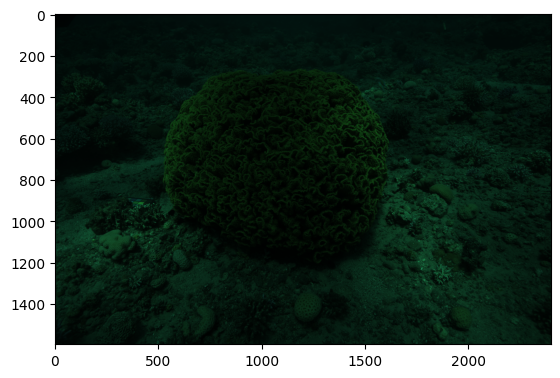

In [7]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [8]:
png.dtype

dtype('float64')

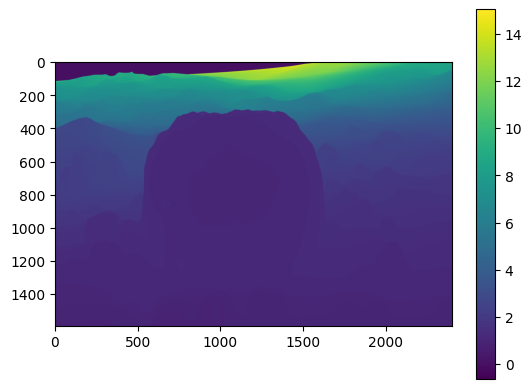

In [9]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [10]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [11]:
tif.min(), tif.max()

(np.float32(-0.6519402), np.float32(15.057854))

In [12]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

In [13]:
# kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
# labels = np.zeros(tif_flat.shape, dtype=np.uint8)
# labels[tif_flat != 0] = kmeans.labels_
# labels[tif_flat == 0] = 255 # Use 255 to represent nan
# means = np.array(kmeans.cluster_centers_).flatten()
# means_args = np.argsort(means)

# labels_new = np.zeros_like(labels)
# labels_new[labels == 255] = clusters + 1

# for current_label in range(clusters):
#     new_label = np.nonzero(means_args == current_label)[0]
#     labels_new[labels == current_label] = new_label

# labels = labels_new.reshape((height, width))
# imshow(labels)

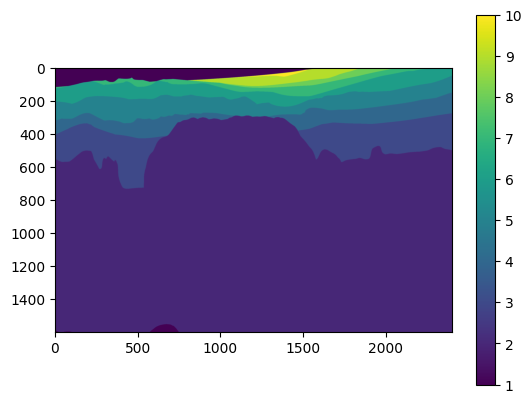

In [14]:
_, edges = np.histogram(tif_flat, clusters)

labels = np.zeros(tif.shape, dtype=np.uint8)
for i in range(clusters + 1):
    labels[np.logical_and(tif <= edges[i], labels == 0)] = i

imshow(labels)

In [15]:
np.unique_counts(labels)

UniqueCountsResult(values=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8), counts=array([ 104560, 2716027,  296174,  172280,  237431,  171081,   62727,
         22950,   42984,    4186]))

In [16]:
dark_pixels = []
z_values = []

for i in range(1, clusters + 1):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    pixel_means = pixels.mean(axis=1)
    idx = np.argsort(pixel_means)[:int(round(float(len(pixel_means)) * 0.01))]
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())
    # break

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [17]:
idx

array([ 302,  343,  341,  348,  220,  209,  259,  263,  618,  619,  620,
        621, 4180, 4174, 4173, 4185,  549,  550,  551,  553,  555, 4168,
       4169,  693,  692,  499,  502,  488,   46,   47,  622,  616,  435,
        436,  438,  439,  440,  441,  442,  443,  444,   83])

In [18]:
len(idx) / pixels.shape[0]

0.010033444816053512

In [19]:
pixels <= np.percentile(pixels, 1, axis=0), pixels[0],  np.percentile(pixels, 1, axis=0)

(array([[False, False,  True],
        [False, False,  True],
        [False, False,  True],
        ...,
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True]], shape=(4186, 3)),
 array([0.05098039, 0.0627451 , 0.00784314]),
 array([0.04705882, 0.05882353, 0.00784314]))

In [20]:
png.shape, 1596 * 2400

((1596, 2400, 3), 3830400)

In [21]:
dark_pixels.shape[0] / (1596 * 2400), z_values.shape

(0.010000261069340016, (38305,))

In [22]:
tif.min(), tif.max()

(np.float32(-0.6519402), np.float32(15.057854))

In [23]:
z_values

array([ 0.91839951,  0.9185155 ,  0.91862816, ..., 13.58451843,
       13.56206703, 14.83998299], shape=(38305,))

In [24]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [25]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z) - B_hat

In [26]:
def leastsquares_estimate_backscatter(dark_pixels: np.ndarray, z_values: np.ndarray, color_channel: int, starts=10):
    lo = np.array([0, 0, 0, 0])
    hi = np.array([1, 5, 1, 5])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4)
        starting_point[1] *= 5
        starting_point[3] *= 5

        print(starting_point)

        try:
            result = least_squares(optimize_estimate_backscatter, starting_point, args=(dark_pixels[:, color_channel], z_values), loss='soft_l1', bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        loss = np.linalg.norm(optimize_estimate_backscatter(params, dark_pixels[:, color_channel], z_values))

        print(loss, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [27]:
# dsssdfsd

In [28]:
dark_pixels

array([[0.00392157, 0.00784314, 0.        ],
       [0.00392157, 0.00784314, 0.        ],
       [0.00392157, 0.00784314, 0.        ],
       ...,
       [0.04705882, 0.05882353, 0.00784314],
       [0.04705882, 0.05882353, 0.00784314],
       [0.04705882, 0.05882353, 0.00784314]], shape=(38305, 3))

In [29]:
b_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 0)

b_args, loss

[0.99166297 0.40843011 0.37536097 1.98269407]
0.4619500831380228 [0.07395262 0.0651126  0.01155267 5.        ]
[0.93508882 1.650419   0.09154512 1.53869402]
0.4619500831379728 [0.07395261 0.06511262 0.01155267 5.        ]
[0.95253619 1.31393087 0.64665129 0.69095652]
0.46195008313803715 [0.07395263 0.0651126  0.01155267 5.        ]
[0.72749601 1.42299493 0.61665434 1.35159311]
0.4619500831378832 [0.07395259 0.06511264 0.01155267 5.        ]
[0.04176994 0.81351212 0.57105702 3.34069387]
0.461950083143795 [0.07395305 0.06511213 0.01155268 5.        ]
[0.36609617 1.77446489 0.64770569 3.04464744]
0.46195008313800134 [0.07395262 0.06511261 0.01155267 5.        ]
[0.00583897 1.2201464  0.01169328 3.86184449]
0.46195008313941915 [0.07395279 0.06511242 0.01155267 5.        ]
[0.47185965 4.7671389  0.3704329  2.35772766]
0.4619500831380093 [0.07395262 0.06511261 0.01155267 5.        ]
[0.0097134  4.71178875 0.46862483 0.23694626]
0.46195008313782365 [0.07395258 0.06511265 0.01155267 5.        

(array([0.07395258, 0.06511265, 0.01155267, 5.        ]),
 np.float64(0.46195008313782365))

In [30]:
g_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 1)

g_args, loss

[0.26000164 4.40861528 0.18969851 4.42716142]
0.5654611543657269 [0.05708135 0.14686173 0.01157833 5.        ]
[0.31863881 0.32281552 0.60696094 1.99509107]
0.5654611543659005 [0.05708136 0.1468617  0.01157833 5.        ]
[0.03714451 4.71470784 0.95961245 3.21147941]
0.5654611543660303 [0.05708136 0.14686169 0.01157833 5.        ]
[0.38318832 0.61147619 0.56410605 1.90945077]
0.5654611543659808 [0.05708136 0.14686169 0.01157833 5.        ]
[0.2355146  3.58350083 0.72909764 1.96613569]
0.5654611543708359 [0.05708145 0.14686132 0.01157833 5.        ]
[0.99791696 2.27014189 0.59741688 3.06641257]
0.5654611543653189 [0.05708132 0.14686185 0.01157833 5.        ]
[0.21300983 3.16227846 0.64614443 2.73528249]
0.565461154365821 [0.05708135 0.14686172 0.01157833 5.        ]
[0.07664773 0.39925632 0.77000113 2.10689604]
0.5654611543659693 [0.05708136 0.14686169 0.01157833 5.        ]
[0.04336404 4.65606636 0.80983209 2.7602846 ]
0.565461154365797 [0.05708135 0.14686172 0.01157833 5.        ]
[0.

(array([0.05708132, 0.14686185, 0.01157833, 5.        ]),
 np.float64(0.5654611543653189))

In [31]:
r_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 2)

r_args, loss

[0.7686019  2.50438037 0.34753876 4.92226254]
0.19530077613260857 [2.47015802e-02 2.54928684e-02 2.86143058e-18 5.00000000e+00]
[0.95606391 1.38162315 0.13323989 2.01808656]
0.19530077613269003 [2.47017066e-02 2.54927248e-02 4.72117144e-18 5.00000000e+00]
[0.59843639 1.79961188 0.20790371 2.29591808]
0.19530077613264665 [2.47016478e-02 2.54927916e-02 1.97782751e-18 5.00000000e+00]
[0.71461455 4.66394699 0.40118094 2.96025459]
0.1953007761327105 [2.47017306e-02 2.54926976e-02 1.15188504e-17 5.00000000e+00]
[0.01877456 0.68378931 0.80696743 2.14856118]
0.1953007761326098 [2.47015828e-02 2.54928655e-02 1.41538968e-18 5.00000000e+00]
[0.56367369 2.5714891  0.76873856 2.40697223]
0.19530077613296765 [2.47014427e-02 2.54930245e-02 9.38449550e-13 5.00000000e+00]
[0.72304123 2.44127656 0.51395268 4.51754831]
0.19530077613260213 [2.47015659e-02 2.54928846e-02 2.53555800e-17 5.00000000e+00]
[0.13368229 1.03898945 0.16121644 0.38456149]
0.19530077613280433 [2.47014835e-02 2.54929782e-02 5.3882400

(array([2.47015659e-02, 2.54928846e-02, 2.53555800e-17, 5.00000000e+00]),
 np.float64(0.19530077613260213))

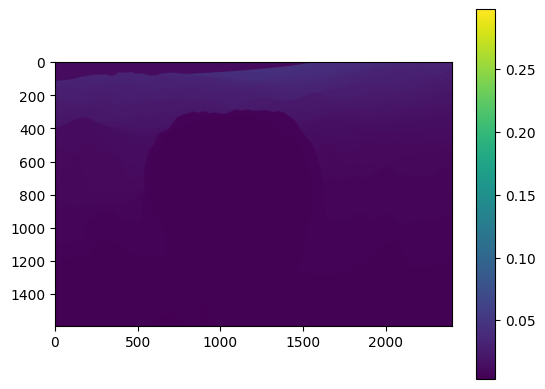

In [32]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

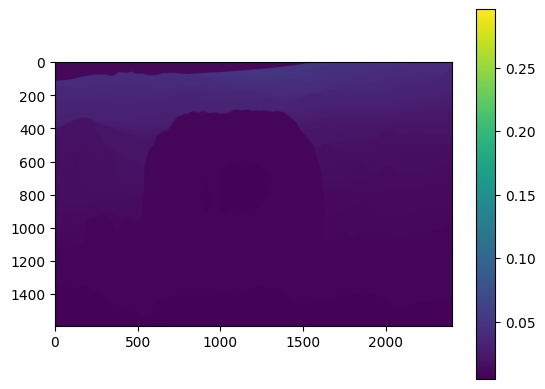

In [33]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

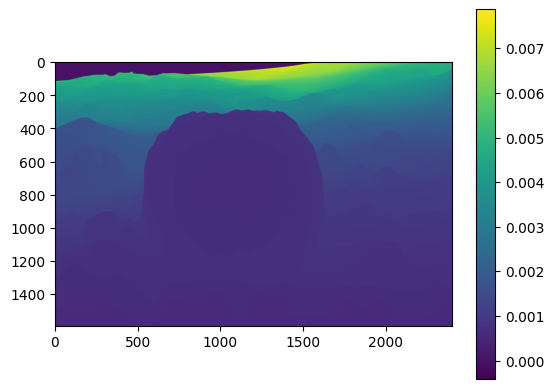

In [34]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

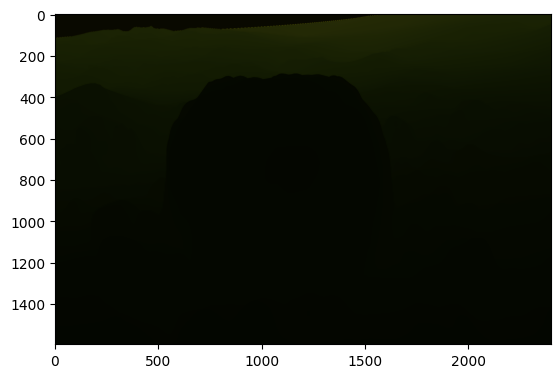

In [35]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

In [36]:
png

array([[[0.01176471, 0.01568627, 0.        ],
        [0.01176471, 0.01568627, 0.        ],
        [0.01176471, 0.01568627, 0.        ],
        ...,
        [0.04313725, 0.0627451 , 0.00784314],
        [0.04313725, 0.0627451 , 0.00784314],
        [0.04313725, 0.0627451 , 0.00784314]],

       [[0.01176471, 0.01568627, 0.        ],
        [0.01176471, 0.01568627, 0.        ],
        [0.01176471, 0.01568627, 0.        ],
        ...,
        [0.04313725, 0.0627451 , 0.00784314],
        [0.04313725, 0.0627451 , 0.00784314],
        [0.04313725, 0.0627451 , 0.00784314]],

       [[0.01176471, 0.01568627, 0.        ],
        [0.01176471, 0.01568627, 0.        ],
        [0.01176471, 0.01568627, 0.        ],
        ...,
        [0.04313725, 0.0627451 , 0.00784314],
        [0.04313725, 0.0627451 , 0.00784314],
        [0.04313725, 0.0627451 , 0.00784314]],

       ...,

       [[0.01568627, 0.02745098, 0.00392157],
        [0.01960784, 0.02745098, 0.00392157],
        [0.01960784, 0

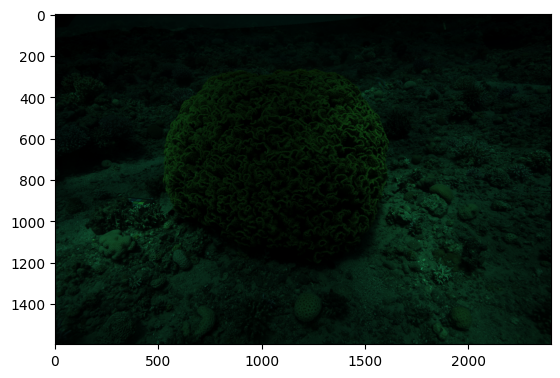

In [37]:
direct_signal = png - backscatter

# sig_min_b = direct_signal[:, :, 0].min()
# sig_min_g = direct_signal[:, :, 1].min()
# sig_min_r = direct_signal[:, :, 2].min()

# if sig_min_b > 0:
#     sig_min_b = 0

# if sig_min_g > 0:
#     sig_min_g = 0

# if sig_min_r > 0:
#     sig_min_r = 0

# direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
# direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
# direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

direct_signal = np.clip(direct_signal, 0, 1)

imshow(direct_signal, color_channel="bgr")

In [38]:
direct_signal

array([[[0.00021203, 0.00410794, 0.        ],
        [0.00021203, 0.00410794, 0.        ],
        [0.00021203, 0.00410794, 0.        ],
        ...,
        [0.01201343, 0.02231508, 0.00308726],
        [0.01202188, 0.02232249, 0.0030888 ],
        [0.01202873, 0.0223285 , 0.00309005]],

       [[0.00021203, 0.00410794, 0.        ],
        [0.00021203, 0.00410794, 0.        ],
        [0.00021203, 0.00410794, 0.        ],
        ...,
        [0.01201343, 0.02231508, 0.00308726],
        [0.01202188, 0.02232249, 0.0030888 ],
        [0.01202873, 0.0223285 , 0.00309005]],

       [[0.00021203, 0.00410794, 0.        ],
        [0.00021203, 0.00410794, 0.        ],
        [0.00021203, 0.00410794, 0.        ],
        ...,
        [0.01203129, 0.02233075, 0.00309052],
        [0.01203728, 0.022336  , 0.00309161],
        [0.01204088, 0.02233916, 0.00309226]],

       ...,

       [[0.01131318, 0.02019394, 0.00335568],
        [0.01523475, 0.02019394, 0.00335568],
        [0.01523223, 0

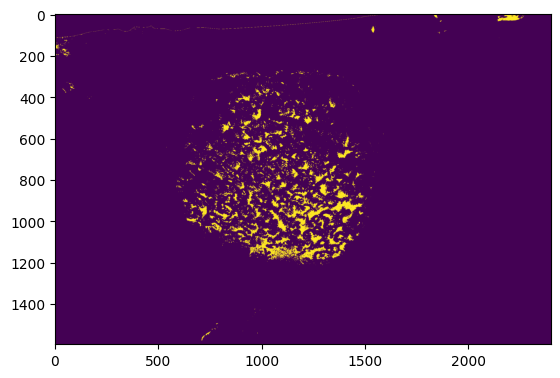

In [39]:
plt.imshow((png < backscatter)[:, :, 0])

In [42]:
np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

direct_signal.shape

(1596, 2400, 3)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [43]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0
p = 0.1

In [44]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(1.5709795)

In [45]:
def pad_tensor(tensor: torch.Tensor, top: int, right: int, left: int, bottom: int) -> torch.Tensor:
    dim = len(tensor.shape)

    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    new_height = height + top + bottom
    new_width = width + right + left

    bottom_idx = new_height - bottom
    right_idx = new_width - right

    padded = torch.zeros((new_height, new_width, channels), device=device)
    padded[top:bottom_idx, left:right_idx, :] = tensor

    if dim == 2:
        return padded[:, :]
    else:
        return padded


In [46]:
def pad_direction(tensor: torch.Tensor):
    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    direction = torch.zeros((height + 2, width + 2, 4, channels), device=device)
    direction[:, :, 0, :] = pad_tensor(tensor, 2, 1, 1, 0)
    direction[:, :, 1, :] = pad_tensor(tensor, 1, 2, 0, 1)
    direction[:, :, 2, :] = pad_tensor(tensor, 0, 1, 1, 2)
    direction[:, :, 3, :] = pad_tensor(tensor, 1, 0, 2, 1)

    return direction

In [47]:
direct_signal_tensor = pad_tensor(torch.as_tensor(direct_signal, device=device), 1, 1, 1, 1)
a_values_tensor = direct_signal_tensor
depths_tensor = torch.as_tensor(tif, device=device)
diff_depth_map_tensor = torch.abs(torch.dstack([pad_tensor(depths_tensor, 1, 1, 1, 1)] * 4) - pad_direction(depths_tensor).squeeze())
softmax = func.softmax(-diff_depth_map_tensor, dim=-1)
weights = torch.stack([softmax] * 3, dim=-1)

for i in range(100):
    a_values_tensor = pad_direction(a_values_tensor[1:-1, 1:-1, :])
    a_values_tensor = torch.sum(weights * a_values_tensor, axis=2)
    a_values_tensor = (1 - p) * a_values_tensor + p * direct_signal_tensor

a_values_tensor.shape

torch.Size([1598, 2402, 3])

In [48]:
a_values = a_values_tensor[1:-1, 1:-1, :].detach().cpu().numpy()

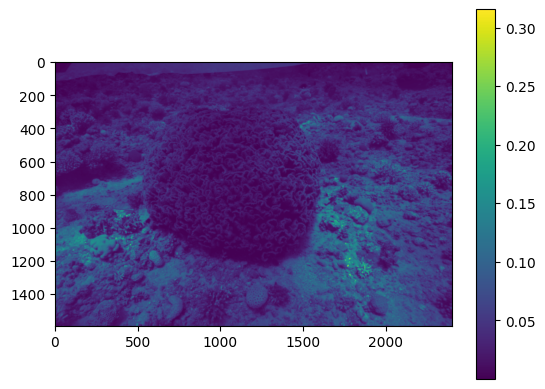

In [49]:
imshow(a_values[:, :, 0])

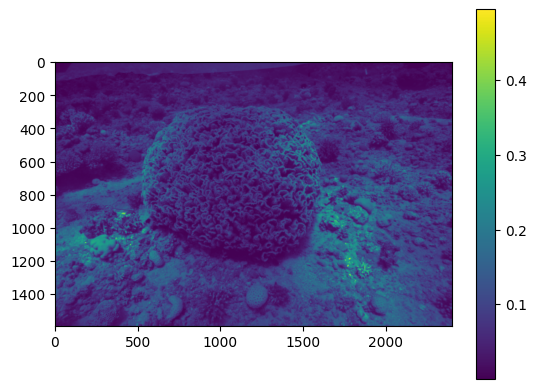

In [50]:
imshow(a_values[:, :, 1])

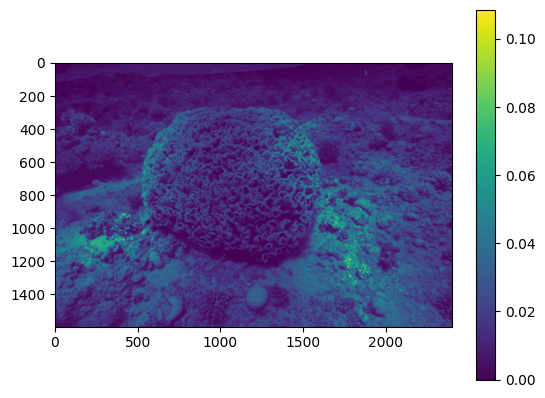

In [51]:
imshow(a_values[:, :, 2])

0.9900659


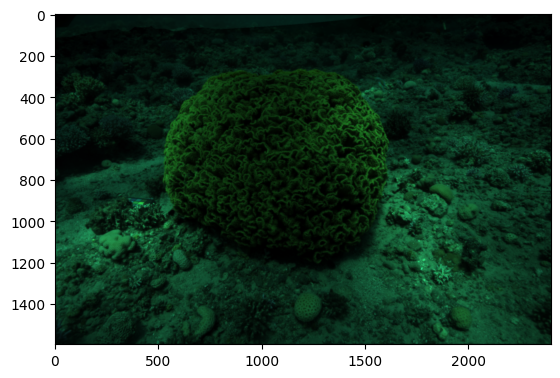

In [52]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map / local_illuminant_map.max(), color_channel="bgr")

In [53]:
np.sort(local_illuminant_map.flatten()), (local_illuminant_map[:, :, 0] <= 0).mean()

(array([7.3013033e-29, 1.5894045e-28, 2.0457815e-28, ..., 9.7518539e-01,
        9.7800201e-01, 9.9006587e-01], shape=(11491200,), dtype=float32),
 np.float64(0.0))

C:\Users\seanh\AppData\Local\Temp\ipykernel_14452\3958786762.py:3: RuntimeWarning: divide by zero encountered in divide
  beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
C:\Users\seanh\AppData\Local\Temp\ipykernel_14452\3958786762.py:4: RuntimeWarning: divide by zero encountered in divide
  beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
C:\Users\seanh\AppData\Local\Temp\ipykernel_14452\3958786762.py:5: RuntimeWarning: divide by zero encountered in divide
  beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif
C:\Users\seanh\AppData\Local\Temp\ipykernel_14452\3958786762.py:9: RuntimeWarning: invalid value encountered in divide
  imshow((beta_d_coarse - beta_min) / beta_max, color_channel="bgr")


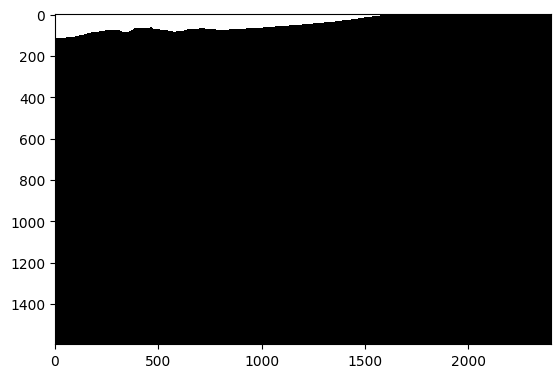

In [54]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

beta_min = beta_d_coarse.min()
beta_max = beta_d_coarse.max() - beta_min
imshow((beta_d_coarse - beta_min) / beta_max, color_channel="bgr")

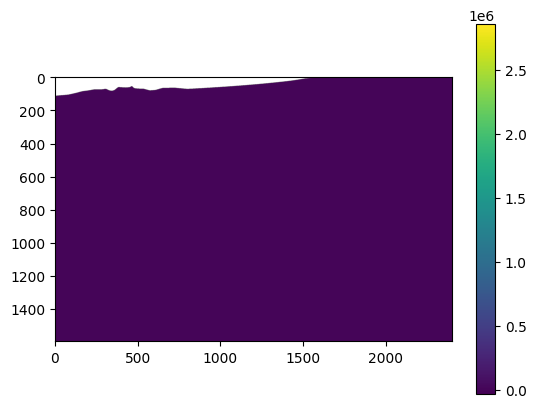

In [55]:
imshow(beta_d_coarse[:, :, 0])

In [56]:
np.sort(beta_d_coarse[:, :, 0].flatten()), np.isnan(beta_d_coarse[:,:,0].flatten()).mean(), (beta_d_coarse[:,:,0].flatten() < 0).mean()

(array([-35637.46 , -29305.639, -21800.84 , ...,        inf,        inf,
               inf], shape=(3830400,), dtype=float32),
 np.float64(0.0),
 np.float64(0.0005143065998329156))

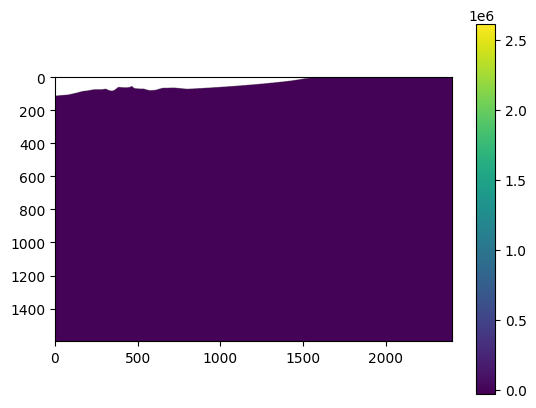

In [57]:
imshow(beta_d_coarse[:, :, 1])

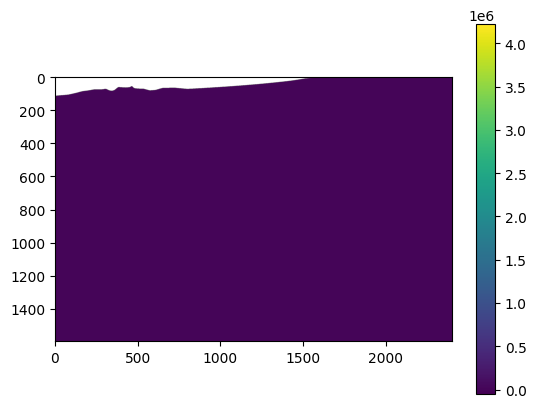

In [58]:
imshow(beta_d_coarse[:, :, 2])

### Refined Estimate of $\beta_c^D(z)$

In [59]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [60]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> np.ndarray[float]:
    a, b, c, d = args
    beta_D = compute_beta_D(a, b, c, d, z)
    z_hat = -np.log(E) / beta_D

    return (z - z_hat).flatten()

In [61]:
def leastsquares_compute_beta_D(local_illuminant_map: np.ndarray, depths: np.ndarray, color_channel: int, starts=50):
    lo = np.array([0, -np.inf, 0, -np.inf])
    hi = np.array([np.inf, 0, np.inf, 0])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4) * 2000
        starting_point[1] /= -10
        starting_point[3] /= -10

        print(starting_point)

        try:
            result = least_squares(optimize_compute_beta_D, starting_point, args=(local_illuminant_map[:, :, color_channel], depths), bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        result = optimize_compute_beta_D(params, local_illuminant_map[:, :, color_channel], depths)
        max_diff = np.abs(result).max()
        loss = np.linalg.norm(result)

        print(loss, max_diff, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [ ]:
local_illuminant_params_b, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 0)

local_illuminant_params_b, loss #0.282

[1547.54975329 -167.85279947  550.33863913 -196.93897282]


C:\Users\seanh\AppData\Local\Temp\ipykernel_14452\1999039822.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D
C:\Users\seanh\AppData\Local\Temp\ipykernel_14452\1999039822.py:4: RuntimeWarning: overflow encountered in divide
  z_hat = -np.log(E) / beta_D


[ 499.4322228   -16.34698872 1974.3749795   -54.33230947]


c:\Users\seanh\Desktop\Color Space Consistency Experiments\pyAqua3dDev\.venv\Lib\site-packages\scipy\optimize\_lsq\common.py:141: RuntimeWarning: invalid value encountered in scalar multiply
  alpha = max(0.001 * alpha_upper, (alpha_lower * alpha_upper)**0.5)
c:\Users\seanh\Desktop\Color Space Consistency Experiments\pyAqua3dDev\.venv\Lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in square
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
c:\Users\seanh\Desktop\Color Space Consistency Experiments\pyAqua3dDev\.venv\Lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
c:\Users\seanh\Desktop\Color Space Consistency Experiments\pyAqua3dDev\.venv\Lib\site-packages\scipy\optimize\_lsq\common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
c:\Users\seanh\Desktop\Colo

1.1755483426830845e+105 7.315611297210334e+104 [ 499.4322228   -16.34698872 1974.3749795   -54.33230947]
[ 262.98119917  -56.76343943  632.96905908 -187.22393768]
[1701.14454114  -13.94119472 1565.61059636 -159.90221912]
6.841741567700438e+88 3.9736825711113415e+88 [1701.14454114  -13.94119472 1565.61059636 -159.90221912]
[1371.15355364   -5.78507473 1139.20240125  -28.92999011]
4870243945.15609 1574863709.903279 [ 3.44860547e+28 -5.66879024e+00  1.13920240e+03 -2.89299901e+01]
[1294.5687527    -7.47399653 1727.10793095  -40.87180332]
2254055508.457244 896861482.9160321 [ 1.14782365e+40 -7.39374402e+00  1.72710793e+03 -4.08718033e+01]
[1340.76472703 -156.28103548 1783.02678098  -36.44535111]


c:\Users\seanh\Desktop\Color Space Consistency Experiments\pyAqua3dDev\.venv\Lib\site-packages\scipy\optimize\_lsq\trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale


[ 111.32484437 -125.55363644 1097.31235629 -184.14170992]
[1819.09200441 -108.71893616 1285.4499565   -67.84250037]
[ 374.2808986  -193.18443389  999.10028249  -92.00837863]
[1699.14061768 -106.32641749 1932.85783279 -134.99813503]
[ 966.70300124 -128.32005789  900.15557961 -155.34730368]
[1526.7645329   -80.07003651   70.28235088  -94.48126846]
[783.17071268  -2.90949875  54.5510948  -36.85793508]


In [ ]:
local_illuminant_params_g, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 1)

local_illuminant_params_g, loss # 0.407

[ 799.30064361 -168.94056531 1279.99286844 -136.92583986]
2.6998105753939385e+123 9.764749043713269e+121 [ 799.30064361 -168.94056531 1279.99286844 -136.92583986]
[ 562.04396515 -136.47497137 1670.01280623  -25.36635842]
3197.231315797334 15.608137377852184 [ 5.62043965e+02 -2.86563226e+12  4.66614845e+17 -2.03753971e+01]
[1531.67502322  -56.7070904   436.43894355 -130.25647474]
6268978096.522213 134762824.89025623 [ 8.70021483e+42 -5.56684077e+01  4.36438944e+02 -1.30256475e+02]
[1386.31150744 -175.00004065   25.43583651 -165.71588507]
2.066272667931517e+151 8.316682689062067e+149 [1386.31150744 -175.00004065   25.43583651 -165.71588507]
[ 900.7724582   -39.12086318  589.97202559 -139.72203722]
6744613405.909923 112281171.53948547 [ 1.31268380e+27 -3.82148948e+01  5.89972026e+02 -1.39722037e+02]
[ 423.15545583  -90.555713   1975.8705588   -88.55723846]
2.391215527951109e+78 6.783954701554431e+76 [ 3385.22760223   -90.555713   15806.96507139   -88.55723846]
[ 262.66824523 -103.99439556

/tmp/ipykernel_267424/1999039822.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D


3083.2334045178077 5.30759670315021 [ 3.54255863e+01 -1.30142307e+16  6.38320611e+22 -2.55985000e+01]
[1110.64923463  -92.57138838   97.78544242 -112.88751437]
1.5115454656596863e+83 4.397030204508917e+81 [1110.64923463  -92.57138838   97.78544242 -112.88751437]
[ 257.47425885   -6.71324836  333.76215627 -130.37637248]
1306.4112968015388 14.668133258624547 [   6.13165331   -0.9610705   333.76215627 -130.37637248]
[1003.12810447 -107.24514894  349.05074354  -48.58544255]
8.57896055243143e+17 1.6307891251175242e+16 [ 1.00312810e+03 -4.12638872e+14  1.61322853e+26 -4.61747262e+01]
[ 245.93998165 -150.26566062 1912.70456174 -120.17354931]
1.06295150127227e+108 3.5761904392525896e+106 [ 245.93998165 -150.26566062 1912.70456174 -120.17354931]
[1702.66498225 -115.73522665  886.04454635  -70.37436509]
4.19880544402475e+62 1.0425296161152828e+61 [1702.66498225 -115.73522665 2808.96108041  -70.37436509]
[ 508.38749002  -72.74828784 1014.42281477 -187.90153694]
3.308658081401159e+65 8.37815825548

(array([ 2.26371741e+01, -2.56178072e+04,  6.13082712e+00, -9.60991911e-01]),
 np.float64(1306.4112955053774))

In [ ]:
local_illuminant_params_r, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 2)

local_illuminant_params_r, loss # 0.205

[415.42785573 -57.80937725  53.61586305  -8.30515506]
674.4217954282508 5.247190971739598 [ 2.69018691e+03 -9.76212542e+05  8.35407661e+00 -8.50153726e-01]
[ 238.83911812 -151.264555    719.01748034  -93.48134679]
2.9676667582489716e+84 7.86314208124329e+82 [ 238.83911812 -151.264555    719.01748034  -93.48134679]
[ 346.00974148  -91.29324109 1828.6727553  -186.26434069]
6.343968722209909e+82 1.6589084450504329e+81 [ 346.00974148  -91.29324109 1828.6727553  -186.26434069]
[1279.92986258 -131.44853223 1878.47645637  -77.64790712]
4.740257233330944e+69 1.1319526846719423e+68 [1279.92986258 -131.44853223 1878.47645637  -77.64790712]
[ 549.76235187 -144.52207274  565.29621231  -73.73278888]
9.782556858840606e+64 2.2682965737591646e+63 [  549.76235187  -144.52207245 25418.69074418   -73.73278888]
[889.46686393 -57.14476068 508.16091683 -88.75034136]
6926416320.444567 136895434.66518053 [ 4.47869116e+43 -5.61994981e+01  5.08160917e+02 -8.87503414e+01]
[ 579.64120104 -115.46856675  183.487434

(array([ 2.69018691e+03, -9.76212542e+05,  8.35407661e+00, -8.50153726e-01]),
 np.float64(674.4217954282508))

In [ ]:
# local_illuminant_params_b = np.array([40.36737389, -5.24498546, 40.36737389, -5.24498546])
# local_illuminant_params_g = np.array([51.71813242, -4.92373242, 51.71813242, -4.92373242])
# local_illuminant_params_r = np.array([53.08643292, -5.8253201 , 53.08643292, -5.8253201 ])

In [ ]:
b_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 0], tif)).mean()
g_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 1], tif)).mean()
r_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 2], tif)).mean()

b_loss, g_loss, r_loss

(np.float64(0.35017766519485954),
 np.float64(0.6345641216544103),
 np.float64(0.45649046701917667))

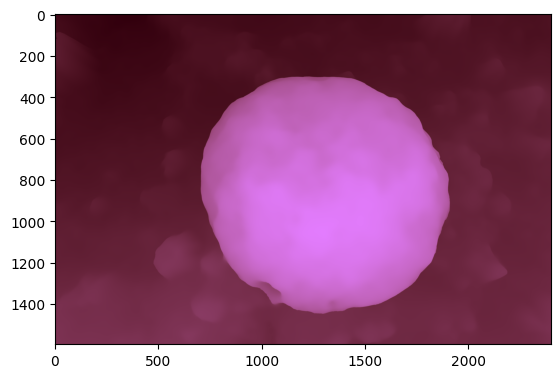

In [ ]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(local_illuminant_params_b[0], local_illuminant_params_b[1], local_illuminant_params_b[2], local_illuminant_params_b[3], tif)
beta_d[:, :, 1] = compute_beta_D(local_illuminant_params_g[0], local_illuminant_params_g[1], local_illuminant_params_g[2], local_illuminant_params_g[3], tif)
beta_d[:, :, 2] = compute_beta_D(local_illuminant_params_r[0], local_illuminant_params_r[1], local_illuminant_params_r[2], local_illuminant_params_r[3], tif)

beta_d_min = beta_d.min()
beta_d_max = beta_d.max() - beta_d_min
imshow((beta_d - beta_d_min) / beta_d_max, color_channel="bgr")

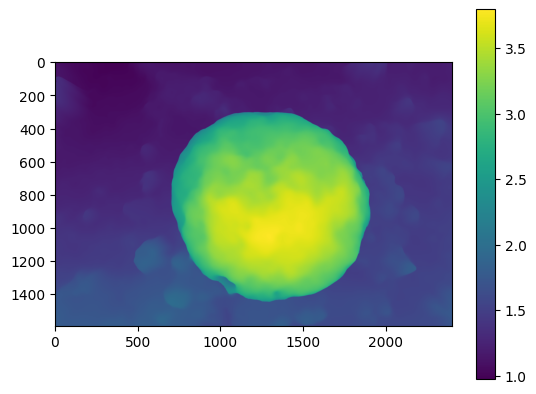

In [ ]:
imshow(beta_d[:, :, 0])

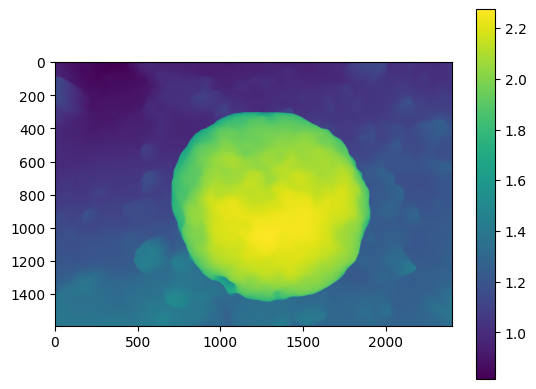

In [ ]:
imshow(beta_d[:, :, 1])

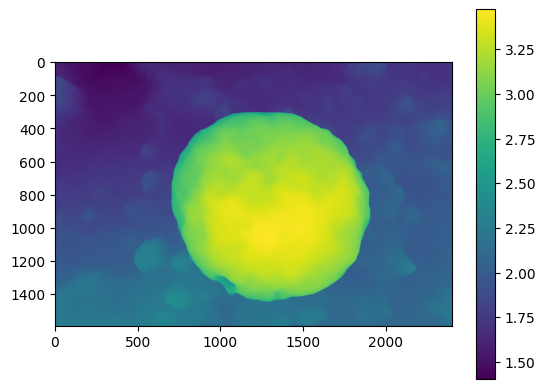

In [ ]:
imshow(beta_d[:, :, 2])

In [ ]:
(direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)).max()

np.float64(7.463869976756204)

In [ ]:
(direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)).max()

np.float64(6.463473454418518)

In [ ]:
(direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)).max()

np.float64(4.571025192190642)

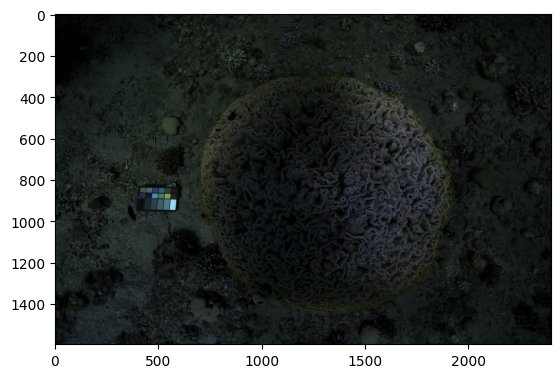

In [ ]:
J = np.zeros_like(direct_signal)

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

# J[:, :, 0] = J[:, :, 0] / J[:, :, 0].max()
# J[:, :, 1] = J[:, :, 1] / J[:, :, 1].max()
# J[:, :, 2] = J[:, :, 2] / J[:, :, 2].max()

J = J / J.max()

imshow(J, color_channel="bgr")

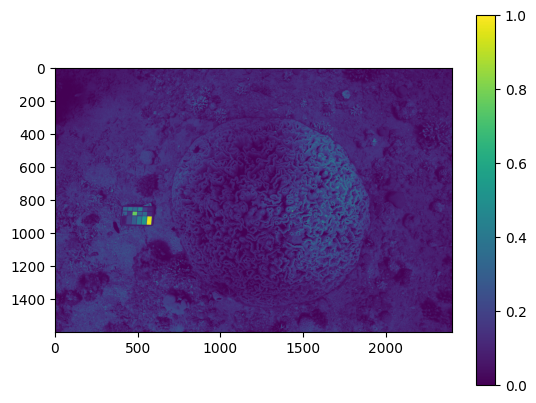

In [ ]:
imshow(J[:, :, 0])

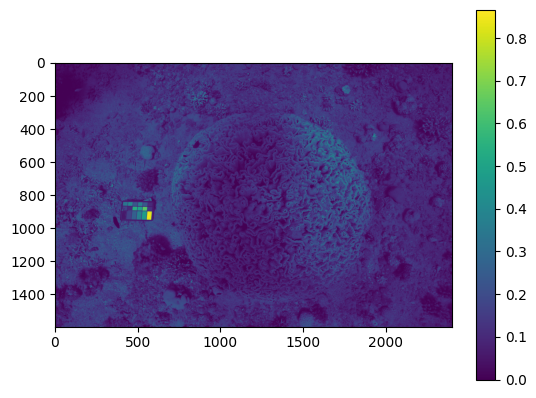

In [ ]:
imshow(J[:, :, 1])

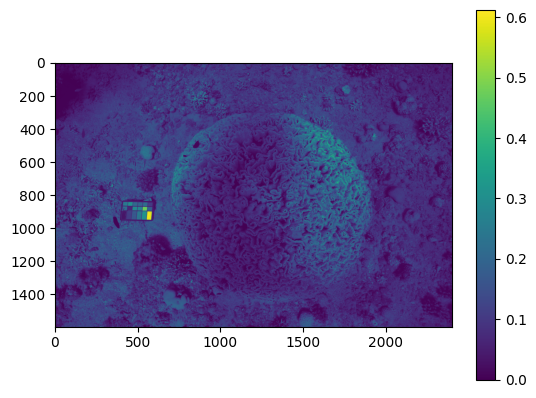

In [ ]:
imshow(J[:, :, 2])

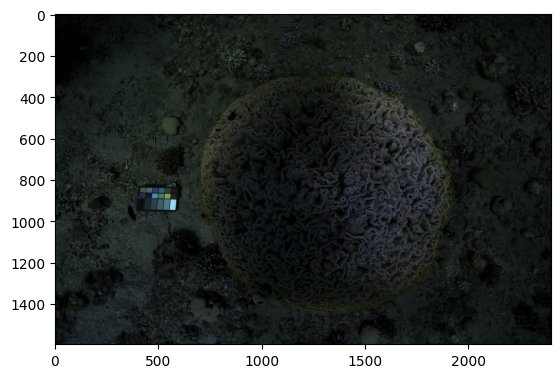

In [ ]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [ ]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [ ]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

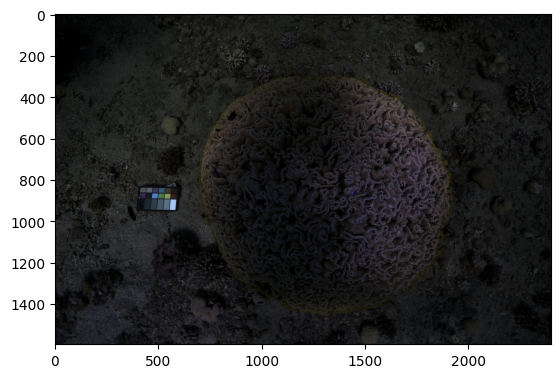

In [ ]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [ ]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

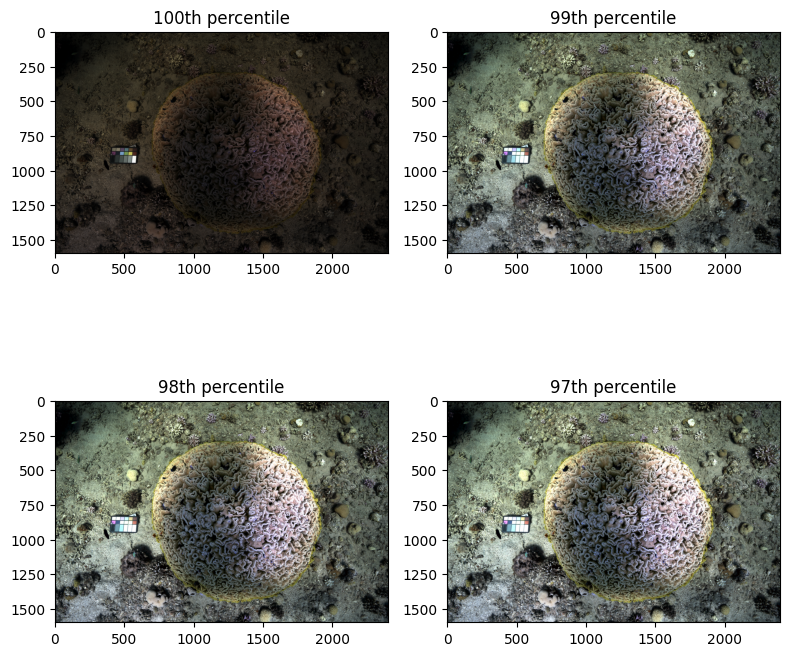

In [ ]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

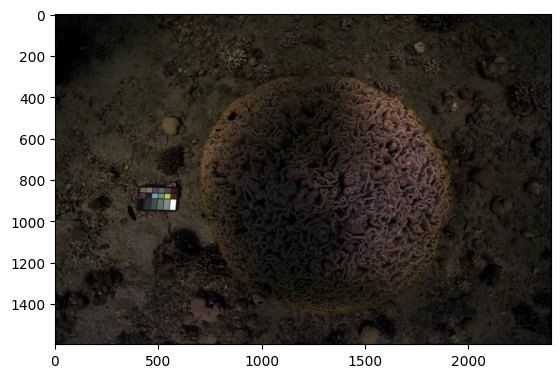

In [ ]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte(white_patch(op_wp, 100))

imshow(img, color_channel="bgr")

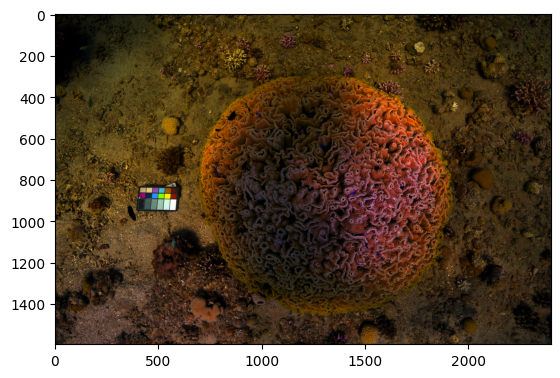

In [ ]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2.2
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

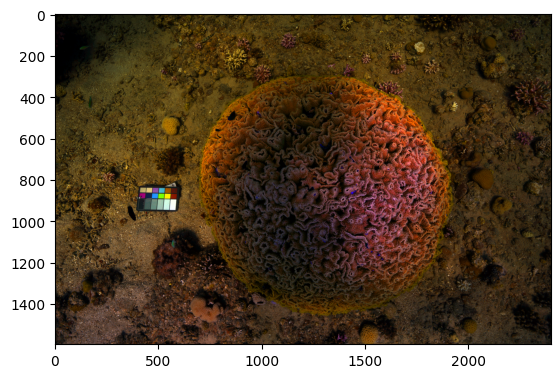

In [ ]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

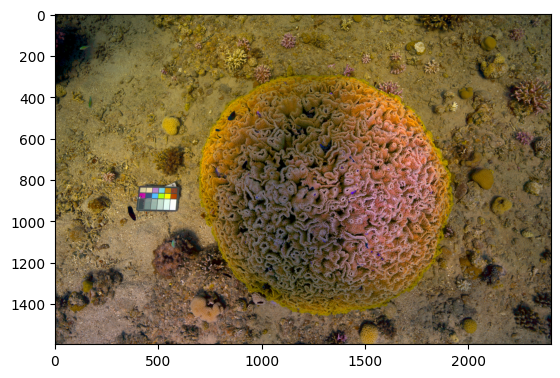

In [ ]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.55)

imshow(img_gamma, color_channel="bgr")

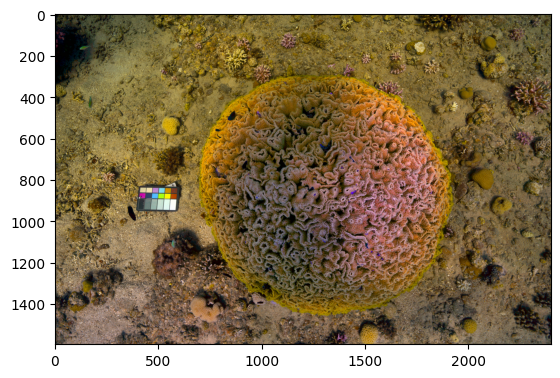

In [ ]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [ ]:
cv2.imwrite("output/crutchfield_perry_final.png", img_as_ubyte(img_hist))

True